In [1]:
import sys
sys.path.append("../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from modelsnew import *
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('./data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('./data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
activation = hard_sigmoid
# activation = F.relu
criterion = torch.nn.MSELoss(reduction='none').to(device)

In [5]:
architecture = [784, 500, 10]

x,y = next(iter(train_loader))
x = x.view(x.size(0),-1).to(device).T
y_one_hot = F.one_hot(y, 10).to(device).T

beta = 1
lambda_h = 0.999
lambda_y = 0.999
epsilon = 0.1#0.5
psiv=0.01 #0.9
one_over_epsilon = 1 / epsilon
lr_start = {'ff' : 0.01, 'fb': 0.001, 'lat': 1e-3}
neural_lr_start = 0.25
neural_lr_stop = 1e-3
neural_lr_rule = "divide_by_slow_loop_index"
neural_lr_decay_multiplier = 0.1
model = TwoLayerCorInfoMax(architecture = architecture, lambda_h = lambda_h, lambda_y = lambda_y, psiv=psiv,
                           epsilon = epsilon, activation = activation)
#model.B[1]['weight']=10*model.B[1]['weight']
#model.B[0]['weight']=3*model.B[0]['weight']

In [6]:
trn_acc_list = []
tst_acc_list = []
neural_dynamic_iterations_free = 20
neural_dynamic_iterations_nudged = 50

n_epochs = 50

for epoch_ in range(n_epochs):
    lr = {'ff' : lr_start['ff'] * (0.99)**epoch_, 'fb' : lr_start['fb'] * (0.99)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
            
        h, y_hat = model.batch_step( x, y_one_hot, lr, neural_lr_start, neural_lr_stop,
                                     neural_lr_rule, neural_lr_decay_multiplier,
                                     neural_dynamic_iterations_free, 
                                     neural_dynamic_iterations_nudged, beta)

    trn_acc = evaluateCorInfoMaxV2(model, train_loader, neural_lr_start, neural_lr_stop, neural_lr_rule, neural_lr_decay_multiplier,
                                   neural_dynamic_iterations_free, device = 'cuda', printing = False)
    tst_acc = evaluateCorInfoMaxV2(model, test_loader, neural_lr_start, neural_lr_stop, neural_lr_rule, neural_lr_decay_multiplier,
                                   neural_dynamic_iterations_free, device = 'cuda', printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
#     lr = {'ff' : 0.05 * (0.9)**epoch_, 'fb': 0.05 * (0.9) ** epoch_, 'lat': 1e-3}
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))
    

3000it [01:58, 25.40it/s]
3it [00:00, 23.23it/s]

Epoch : 1, Train Accuracy : 0.5915, Test Accuracy : 0.6001


3000it [01:52, 26.59it/s]
3it [00:00, 24.96it/s]

Epoch : 2, Train Accuracy : 0.7297666666666667, Test Accuracy : 0.7354


3000it [01:54, 26.24it/s]
5it [00:00, 46.13it/s]

Epoch : 3, Train Accuracy : 0.7344833333333334, Test Accuracy : 0.7417


3000it [00:58, 51.38it/s]
5it [00:00, 46.00it/s]

Epoch : 4, Train Accuracy : 0.7533166666666666, Test Accuracy : 0.7639


3000it [00:58, 51.05it/s]
5it [00:00, 47.70it/s]

Epoch : 5, Train Accuracy : 0.7712166666666667, Test Accuracy : 0.7791


3000it [00:58, 51.12it/s]
5it [00:00, 46.71it/s]

Epoch : 6, Train Accuracy : 0.7639833333333333, Test Accuracy : 0.7716


3000it [00:58, 51.16it/s]
5it [00:00, 47.04it/s]

Epoch : 7, Train Accuracy : 0.7663666666666666, Test Accuracy : 0.7761


3000it [00:58, 51.47it/s]
5it [00:00, 47.18it/s]

Epoch : 8, Train Accuracy : 0.7828833333333334, Test Accuracy : 0.7935


3000it [00:58, 51.40it/s]
5it [00:00, 46.26it/s]

Epoch : 9, Train Accuracy : 0.7751, Test Accuracy : 0.7833


3000it [00:58, 51.11it/s]
5it [00:00, 45.90it/s]

Epoch : 10, Train Accuracy : 0.7929166666666667, Test Accuracy : 0.8028


3000it [00:58, 51.02it/s]
5it [00:00, 46.73it/s]

Epoch : 11, Train Accuracy : 0.7869666666666667, Test Accuracy : 0.7956


3000it [00:58, 51.12it/s]
5it [00:00, 46.47it/s]

Epoch : 12, Train Accuracy : 0.7881166666666667, Test Accuracy : 0.7986


3000it [00:58, 51.36it/s]
5it [00:00, 46.87it/s]

Epoch : 13, Train Accuracy : 0.7858833333333334, Test Accuracy : 0.7952


3000it [00:58, 51.35it/s]
5it [00:00, 46.80it/s]

Epoch : 14, Train Accuracy : 0.7869166666666667, Test Accuracy : 0.7992


3000it [00:58, 51.30it/s]
5it [00:00, 47.10it/s]

Epoch : 15, Train Accuracy : 0.7897, Test Accuracy : 0.8001


3000it [00:58, 51.36it/s]
5it [00:00, 47.31it/s]

Epoch : 16, Train Accuracy : 0.7975833333333333, Test Accuracy : 0.8071


3000it [00:58, 51.26it/s]
5it [00:00, 46.86it/s]

Epoch : 17, Train Accuracy : 0.78235, Test Accuracy : 0.7944


3000it [00:58, 51.20it/s]
5it [00:00, 47.11it/s]

Epoch : 18, Train Accuracy : 0.787, Test Accuracy : 0.7951


3000it [00:59, 50.67it/s]
5it [00:00, 46.67it/s]

Epoch : 19, Train Accuracy : 0.7975833333333333, Test Accuracy : 0.8074


3000it [00:59, 50.65it/s]
5it [00:00, 46.81it/s]

Epoch : 20, Train Accuracy : 0.7938833333333334, Test Accuracy : 0.8003


3000it [00:59, 50.55it/s]
5it [00:00, 47.57it/s]

Epoch : 21, Train Accuracy : 0.7943166666666667, Test Accuracy : 0.803


3000it [00:59, 50.49it/s]
5it [00:00, 46.71it/s]

Epoch : 22, Train Accuracy : 0.7949333333333334, Test Accuracy : 0.7992


3000it [00:59, 50.75it/s]
5it [00:00, 46.99it/s]

Epoch : 23, Train Accuracy : 0.7967333333333333, Test Accuracy : 0.8059


3000it [00:59, 50.64it/s]
5it [00:00, 46.62it/s]

Epoch : 24, Train Accuracy : 0.79275, Test Accuracy : 0.7995


3000it [00:59, 50.64it/s]
5it [00:00, 46.70it/s]

Epoch : 25, Train Accuracy : 0.798, Test Accuracy : 0.8077


3000it [00:59, 50.44it/s]
5it [00:00, 46.63it/s]

Epoch : 26, Train Accuracy : 0.79235, Test Accuracy : 0.8


3000it [00:59, 50.07it/s]
5it [00:00, 49.88it/s]

Epoch : 27, Train Accuracy : 0.8002166666666667, Test Accuracy : 0.8092


3000it [00:59, 50.33it/s]
5it [00:00, 49.86it/s]

Epoch : 28, Train Accuracy : 0.8110166666666667, Test Accuracy : 0.8195


3000it [00:59, 50.68it/s]
5it [00:00, 46.19it/s]

Epoch : 29, Train Accuracy : 0.7947333333333333, Test Accuracy : 0.8037


3000it [00:58, 51.12it/s]
5it [00:00, 46.82it/s]

Epoch : 30, Train Accuracy : 0.80305, Test Accuracy : 0.8156


3000it [00:58, 51.10it/s]
5it [00:00, 46.64it/s]

Epoch : 31, Train Accuracy : 0.8046, Test Accuracy : 0.8162


3000it [00:58, 51.00it/s]
5it [00:00, 46.77it/s]

Epoch : 32, Train Accuracy : 0.8004833333333333, Test Accuracy : 0.8122


3000it [00:58, 51.36it/s]
5it [00:00, 47.13it/s]

Epoch : 33, Train Accuracy : 0.7915666666666666, Test Accuracy : 0.7986


3000it [00:58, 51.42it/s]
5it [00:00, 46.27it/s]

Epoch : 34, Train Accuracy : 0.8018833333333333, Test Accuracy : 0.8111


3000it [00:58, 51.30it/s]
5it [00:00, 46.31it/s]

Epoch : 35, Train Accuracy : 0.7962, Test Accuracy : 0.8043


3000it [00:58, 51.35it/s]
4it [00:00, 23.20it/s]

Epoch : 36, Train Accuracy : 0.7964666666666667, Test Accuracy : 0.8023


3000it [00:59, 50.72it/s]
5it [00:00, 46.48it/s]

Epoch : 37, Train Accuracy : 0.8009, Test Accuracy : 0.8086


3000it [00:58, 50.87it/s]
5it [00:00, 46.98it/s]

Epoch : 38, Train Accuracy : 0.7979, Test Accuracy : 0.8093


3000it [00:59, 50.81it/s]
5it [00:00, 46.70it/s]

Epoch : 39, Train Accuracy : 0.7940666666666667, Test Accuracy : 0.8003


3000it [00:59, 50.59it/s]
5it [00:00, 46.42it/s]

Epoch : 40, Train Accuracy : 0.8049833333333334, Test Accuracy : 0.8141


3000it [00:59, 50.36it/s]
5it [00:00, 46.84it/s]

Epoch : 41, Train Accuracy : 0.8060166666666667, Test Accuracy : 0.8165


3000it [00:59, 50.48it/s]
5it [00:00, 46.39it/s]

Epoch : 42, Train Accuracy : 0.80355, Test Accuracy : 0.8098


3000it [00:59, 50.46it/s]
5it [00:00, 46.31it/s]

Epoch : 43, Train Accuracy : 0.7957166666666666, Test Accuracy : 0.81


3000it [00:59, 50.29it/s]
5it [00:00, 46.39it/s]

Epoch : 44, Train Accuracy : 0.7966833333333333, Test Accuracy : 0.8052


3000it [00:59, 50.36it/s]
5it [00:00, 46.19it/s]

Epoch : 45, Train Accuracy : 0.7940833333333334, Test Accuracy : 0.802


3000it [00:59, 50.46it/s]
5it [00:00, 46.90it/s]

Epoch : 46, Train Accuracy : 0.80005, Test Accuracy : 0.8068


3000it [00:59, 50.35it/s]
5it [00:00, 46.50it/s]

Epoch : 47, Train Accuracy : 0.7953166666666667, Test Accuracy : 0.8045


3000it [00:59, 50.44it/s]
5it [00:00, 46.55it/s]

Epoch : 48, Train Accuracy : 0.8032666666666667, Test Accuracy : 0.8117


3000it [00:59, 50.24it/s]
5it [00:00, 46.86it/s]

Epoch : 49, Train Accuracy : 0.80125, Test Accuracy : 0.807


3000it [00:59, 50.30it/s]


Epoch : 50, Train Accuracy : 0.7977666666666666, Test Accuracy : 0.8054


In [7]:
torch.trace(model.B[0]['weight'])/architecture[1]

tensor(748.7748, device='cuda:0')

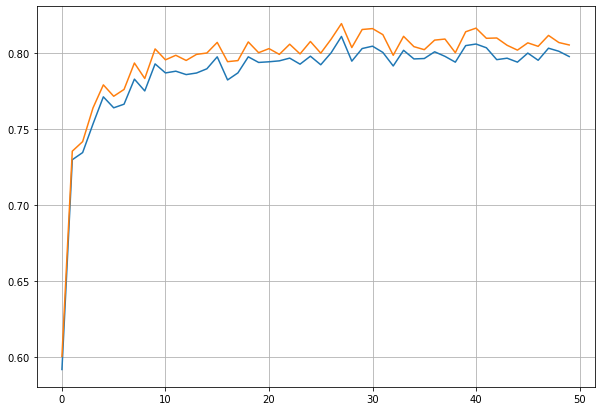

In [11]:
plt.figure(figsize = (10,7))
plt.plot(trn_acc_list)
plt.plot(tst_acc_list)
plt.grid()
plt.show()